In [17]:
import numpy as np
from utils import *
import matplotlib.pyplot as plt
import re
LAMBDA = 2

R: 0.06139202695339918, angle: -2.0, pose: 0.7, perf: 42.1734555870061, cruise cd: 0.015412538312375546, launch cd: 0.004597948864102364


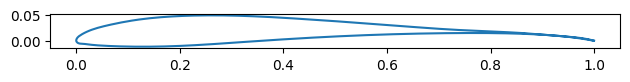

intersection: True, thickness: 0.057672755834301107, thickness pose: 20.5, tail cross pose: 75


In [3]:
points = 'samples/DiffusionAirfoil1DTransform_001.dat'
airfoil = np.loadtxt(points, skiprows=1)
af, R, a, b, perf, cd, CD_BL = lowestD(airfoil, Re2= 400000, lamda = LAMBDA, check_thickness=False)
name = points.split('/')[1].split('.')[0]+f'_{a}_{b}F'
np.savetxt(points.split('.')[0]+f'_{a}_{b}F'+'.dat', af, header=points.split('/')[1].split('.')[0]+f'_{a}_{b}F', comments="")
print(f'R: {R}, angle: {a}, pose: {b}, perf: {perf}, cruise cd: {cd}, launch cd: {CD_BL}')
show_airfoil(af)
print(f'intersection: {detect_intersect(af)}, thickness: {cal_thickness(af)}, thickness pose: {cal_thickness_percent(af)}, tail cross pose: {check_backpoint(af)}')

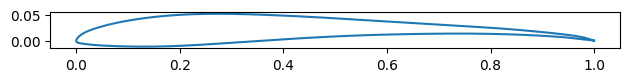

R: 0.02415582165122032, angle: -2.0, pose: 0.7, perf: 41.90921040179586, cruise cd: 0.015509717166423798, launch cd: 0.004323052242398262


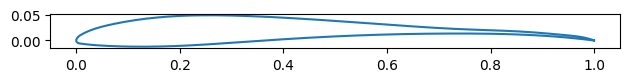

intersection: False, thickness: 0.057818723018408284, thickness pose: 20.5, tail cross pose: 0


In [18]:
points = 'samples/DiffusionAirfoil1DTransform_001.dat'
airfoil = np.loadtxt(points, skiprows=1)
a_up = np.concatenate([np.zeros([10]), np.ones([4]) * 0.001, np.array([0.0001])])
a_low = np.concatenate([np.zeros([10]), np.ones([4]) * -0.001, np.array([0.0001])])
airfoil = mute_airfoil(airfoil, a_up, a_low)
show_airfoil(airfoil)
af, R, a, b, perf, cd, CD_BL = lowestD(airfoil, Re2= 400000, lamda = LAMBDA, check_thickness=False)
name = points.split('/')[1].split('.')[0]+f'_{a}_{b}F'
np.savetxt(points.split('.')[0]+f'_{a}_{b}F'+'.dat', af, header=points.split('/')[1].split('.')[0]+f'_{a}_{b}F', comments="")
print(f'R: {R}, angle: {a}, pose: {b}, perf: {perf}, cruise cd: {cd}, launch cd: {CD_BL}')
show_airfoil(af)
print(f'intersection: {detect_intersect(af)}, thickness: {cal_thickness(af)}, thickness pose: {cal_thickness_percent(af)}, tail cross pose: {check_backpoint(af)}')

In [ ]:
perffile = 'results/Airfoils1D_simperf.log'
f = open(perffile, 'r')
p = re.compile('perf: ')
perfs = []
airfoils = []
Rs = []
for line in f:
    if p.search(line):
        perf = line.split('perf: ')[1].split(', R: ')[0]
        perf = float(perf)
        perfs.append(perf)
        R = line.split(', R: ')[1].split(', m: ')[0]
        R = float(R)
        Rs.append(R)
        airfoilfile = line.split(', path: ')[1]
        airfoils.append(airfoilfile)

perfs = np.array(perfs)
Rs = np.array(Rs)
i = np.argmax(perfs)
k = np.argmin(Rs)
# Rs = np.delete(Rs, k)
# k = np.argmin(Rs)
# Rs = np.delete(Rs, k)
# k = np.argmin(Rs)
print(airfoils[i])
print(airfoils[k], Rs[k], perfs[k])


In [ ]:
f = open(perffile, 'r')
p = re.compile(airfoils[k])
lines = []
for line in f:
    if p.search(line) is not None:
        print(line)
        pass
    else:
        lines.append(line)
f.close()
f = open(perffile, 'w')
for line in lines:
    f.write(line)
f.close()


In [ ]:
i = 49

In [ ]:
print(i)
path = '/work3/s212645/DiffusionAirfoil1DTransform/Airfoils1D/'
path += '000.npy'
afs = np.load(path)
airfoil = afs[i]
airfoil = Normalize(airfoil)
airfoil = derotate(airfoil)
# airfoil = set_thickness_pose(airfoil, 50)
lh_idx = np.argmin(airfoil[:,0])
lh_x = airfoil[lh_idx, 0]
# Get trailing head
th_x = np.minimum(airfoil[0,0], airfoil[-1,0])
# Interpolate
f_up = interp1d(airfoil[:lh_idx+1,0], airfoil[:lh_idx+1,1])
f_low = interp1d(airfoil[lh_idx:,0], airfoil[lh_idx:,1])
xx = np.linspace(lh_x, th_x, num=1000)
yy_up = f_up(xx)
yy_low = f_low(xx)
yy_up1 = yy_up[:-2]
yy_up2 = yy_up[1:-1]
i_up = (np.abs(yy_up2-yy_up1)).argmin()
af_up = np.zeros([i_up,2])
af_up[:i_up,0] = xx[1:i_up+1]
af_up[:i_up,1] = yy_up[1:i_up+1]
af_up = af_up * 0.2 / (af_up[-1,0] - af_up[0,0])
af_up[:,1] = af_up[:,1] * 2 / af_up[-1,1]

yy_up1 = yy_low[:-2]
yy_up2 = yy_low[1:-1]
i_down = (np.abs(yy_up2-yy_up1)).argmin()
af_down = np.zeros([i_down,2])
af_down[:i_down,0] = xx[1:i_down+1]
af_down[:i_down,1] = yy_low[1:i_down+1]
af_down = af_down * 0.2 / (af_down[-1,0] - af_down[0,0])
af_down[:,1] = af_down[:,1] / abs(af_down[-1,1])

fuse = np.zeros([i_down+i_up,2])
fuse[:i_up,:] = np.flip(af_up, axis=0)
fuse[i_up:,:] = af_down
fuse[:,1] = fuse[:,1] * 0.032 / cal_thickness(fuse)

up_ = np.array([[0.45, 0.006]])
down_ = np.array([[0.45, -0.008]])
fuse = np.concatenate([up_, fuse, down_], axis = 0)

# fuse = Normalize(fuse)
fuse = interpolate(fuse, 254, 3)
up_ = np.array([[1.0, -0.008]])
down_ = np.array([[1.0, -0.014]])
fuse = np.concatenate([up_, fuse, down_], axis = 0)
fuse = Normalize(fuse)
fuse = derotate(fuse)

show_airfoil(fuse)
i+=1

In [ ]:
print(evalpreset(fuse))

In [ ]:
np.savetxt(f'F3K_airfoils/fuse.dat', fuse, header=f'fuse', comments="")

In [ ]:
i = 4
print(i)
path = '/work3/s212645/DiffusionAirfoil1DTransform/Airfoils1D/'
path += '000.npy'
afs = np.load(path)
airfoil = afs[i]
airfoil = Normalize(airfoil)
airfoil = derotate(airfoil)
# airfoil = set_thickness_pose(airfoil, 50)
lh_idx = np.argmin(airfoil[:,0])
lh_x = airfoil[lh_idx, 0]
# Get trailing head
th_x = np.minimum(airfoil[0,0], airfoil[-1,0])
# Interpolate
f_up = interp1d(airfoil[:lh_idx+1,0], airfoil[:lh_idx+1,1])
f_low = interp1d(airfoil[lh_idx:,0], airfoil[lh_idx:,1])
xx = np.linspace(lh_x, th_x, num=1000)
yy_up = f_up(xx)
yy_low = f_low(xx)
yy_up1 = yy_up[:-2]
yy_up2 = yy_up[1:-1]
i_up = (np.abs(yy_up2-yy_up1)).argmin()
af_up = np.zeros([i_up,2])
af_up[:i_up,0] = xx[1:i_up+1]
af_up[:i_up,1] = yy_up[1:i_up+1]
af_up[:,0] = af_up[:,0] ** 1.4
af_up = af_up * 0.2 / (af_up[-1,0] - af_up[0,0])
# af_up[:200,0] = af_up[:200,0] * 0.5
# af_up[200:,0] = (af_up[200:,0] -  af_up[200,0]) * 1.25 + af_up[199,0]
# af_up[:,1] = af_up[:,1] * 2 / af_up[-1,1]


af_down = np.copy(af_up)
af_down[:,1] = - af_down[:,1]

fuse = np.zeros([2*i_up,2])
fuse[:i_up,:] = np.flip(af_up, axis=0)
fuse[i_up:,:] = af_down
fuse[:,1] = fuse[:,1] * 0.04 / cal_thickness(fuse)

up_ = np.array([[0.45, 0.008], [0.4, 0.011], [0.3, 0.018]])
down_ = np.array([[0.3, -0.018], [0.4, -0.011], [0.45, -0.008]])
fuse = np.concatenate([up_, fuse, down_], axis = 0)

# # fuse = Normalize(fuse)
fuse = interpolate(fuse, 254, 3)
# up_ = np.array([[1.0, 0.004]])
# down_ = np.array([[1.0, -0.004]])
# fuse = np.concatenate([up_, fuse, down_], axis = 0)
# fuse = Normalize(fuse)
# fuse = derotate(fuse)

show_airfoil(fuse)
i+=1

In [ ]:
np.savetxt(f'F3K_airfoils/fuse_side.dat', fuse, header=f'fuse_side', comments="")

In [ ]:

points = 'samples/Airfoils2D_049.dat'
airfoil = np.loadtxt(points, skiprows=1)
af = setupflap(airfoil, -3, 0.6)
show_airfoil(af)
cd, _ = evalpreset(af)
perf, _, _ = evalperf(setflap(af, 3, 0.6))
cd, cal_thickness(af), cal_thickness_percent(af), perf, check_backpoint(af)

In [ ]:

f = open('results/Airfoils1D_simperf.log', 'r')
a = f.read()
f.close()
files = []
for name in a.split('path: ')[1:]:
    file = name.split('.dat')[0] + '.dat'
    files.append(file)

In [ ]:
for file in files:
    # points = 'samples/Airfoils1D_039.dat'
    # airfoil = np.loadtxt(points, skiprows=1)
    airfoil = np.loadtxt(file, skiprows=1)
    af, R, a, b, perf, cd, CD_BL = lowestD(airfoil, lamda = LAMBDA, check_thickness=False)
    name = file.split('/')[1].split('.')[0]+f'_{a}_{b}F'
    np.savetxt(file.split('.')[0]+f'_{a}_{b}F'+'.dat', af, header=file.split('/')[1].split('.')[0]+f'_{a}_{b}F', comments="")
    print(R, a, b, perf, cd, CD_BL)

In [ ]:
b = np.linspace(0.5, 0.6, num=5) 
a = np.linspace(-3,-1, num=5)
cdbl = 1
for pose in b:
    for alfa in a:
        afp = setupflap(airfoil, theta = alfa, pose = pose)
        cd, aa = evalpreset(afp)
        if cd < cdbl:
            pose_bl = pose
            alfa_bl = alfa
            af_bl = afp
            cdbl = cd
            print(pose_bl, alfa_bl, cdbl)

pose_bl, alfa_bl, cdbl

In [ ]:
points = 'samples/tipAirfoils1D_004.dat'
airfoil = np.loadtxt(points, skiprows=1)
af = setupflap(airfoil, -3, 0.6)
show_airfoil(af)
cd, _ = evalpreset(af, Re=1.4e5)
cd, cal_thickness(af), cal_thickness_percent(af), detect_intersect(af), check_backpoint(af)

In [ ]:
points = 'samples/tipAirfoils1D_018.dat'
airfoil = np.loadtxt(points, skiprows=1)
af = setupflap(airfoil, -3, 0.6)
show_airfoil(af)
cd, _ = evalpreset(af, Re=1.4e5)
cd, cal_thickness(af), cal_thickness_percent(af), detect_intersect(af), check_backpoint(af)

In [ ]:
points = 'samples/tipAirfoils2D_033.dat'
airfoil = np.loadtxt(points, skiprows=1)
af = setupflap(airfoil, -3, 0.6)
show_airfoil(af)
cd, _ = evalpreset(af, Re=1.4e5)
cd, cal_thickness(af), cal_thickness_percent(af), detect_intersect(af), check_backpoint(af)

In [ ]:
points = 'samples/tipAirfoils2D_044.dat'
airfoil = np.loadtxt(points, skiprows=1)
af = setupflap(airfoil, -3, 0.6)
show_airfoil(af)
cd, _ = evalpreset(af, Re=1.4e5)
cd, cal_thickness(af), cal_thickness_percent(af), detect_intersect(af), check_backpoint(af)

In [ ]:
points = 'samples/tipAirfoils1D_004.dat'
airfoil = np.loadtxt(points, skiprows=1)
airfoil = setupflap(airfoil, -3, 0.6)
def set_thickness_pose(airfoil, pose):
    lh_idx = np.argmin(airfoil[:,0])
    lh_x = airfoil[lh_idx, 0]
    # Get trailing head
    th_x = np.minimum(airfoil[0,0], airfoil[-1,0])
    # Interpolate
    f_up = interp1d(airfoil[:lh_idx+1,0], airfoil[:lh_idx+1,1])
    f_low = interp1d(airfoil[lh_idx:,0], airfoil[lh_idx:,1])
    xx = np.linspace(lh_x, th_x, num=1000)
    yy_up = f_up(xx)
    yy_low = f_low(xx)
    max_thickness_index = (yy_up-yy_low).argmax()
    p = pose*10/max_thickness_index
    xxx = np.copy(xx)
    xxx[:max_thickness_index] = xx[:max_thickness_index] * p
    xxx[max_thickness_index:] = (xx[max_thickness_index:] - xx[max_thickness_index]) * (1000 - max_thickness_index * p) / (1000 - max_thickness_index) + xx[max_thickness_index] * p
    f_up = interp1d(xxx, yy_up)
    f_low = interp1d(xxx, yy_low)
    xx = np.linspace(xxx[0], xxx[-1], num=128)
    yy_up = f_up(xx)
    yy_low = f_low(xx)
    airfoil[:128,0] = np.flip(xx)
    airfoil[:128,1] = np.flip(yy_up)
    airfoil[128:,0] = xx
    airfoil[128:,1] = yy_low
    airfoil = np.delete(airfoil, [128], axis=0)
    xhat, yhat = savgol_filter((airfoil[:,0], airfoil[:,1]), 7, 3)
    airfoil[:,0] = xhat
    airfoil[:,1] = yhat
    airfoil = interpolate(airfoil, 256, 3)
    airfoil = derotate(airfoil)
    airfoil = Normalize(airfoil)
    airfoil = interpolate(airfoil, 256, 3)
    return airfoil
airfoil = set_thickness_pose(airfoil, cal_thickness_percent(airfoil)*(1-(25-23)/25))
show_airfoil(airfoil)
cal_thickness_percent(airfoil)


In [ ]:
import os

def rewrite_polar(root):
    for path, dir, files in os.walk(root):
        for file in files:
            lines=[]
            infile = root+file
            with open(infile, 'r') as fin:
                for line in fin:
                    line = line.replace('9.000  9.000', '9.000')
                    lines.append(line)
            fin.close()
            with open(infile, "w") as fout:
                for line in lines:
                    fout.write(line)
            fout.close()

root = 'Airfoils2D_049_0.6F_20_-3/'
rewrite_polar(root)